In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset

C:\Users\USER\anaconda3\envs\preparation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = os.getcwd()
save_path = os.path.join(path,"save")

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1016) # Seed 고정

In [4]:
# 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 이미지 전처리 및 임베딩
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
#     transforms.RandomGrayscale(p=0.25),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
train_data = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform_train)
train_loader = DataLoader(train_data, batch_size=8, shuffle=False)

In [6]:
# CNN 기반 Autoencoder 모델 정의
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.8),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(0.8),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.8),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ELU(0.8),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ELU(0.8),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.8),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ELU(0.8),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = AutoencoderCNN().to(device)
print(model)
# 손실 함수 및 최적화 기준 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
# 모델 학습
num_epochs = 500
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader.dataset)}")

AutoencoderCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.8)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ELU(alpha=0.8)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.8)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ELU(alpha=0.8)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ELU(alpha=0.8)
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.8)
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ELU(alpha=0.8)
    (6): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_paddi

Epoch [163/500], Loss: 0.0003577915380737294
Epoch [164/500], Loss: 0.0003556359702493873
Epoch [165/500], Loss: 0.0003534660740490968
Epoch [166/500], Loss: 0.0003579815024643384
Epoch [167/500], Loss: 0.00042980847027078445
Epoch [168/500], Loss: 0.0004376105989051869
Epoch [169/500], Loss: 0.0004271432145787272
Epoch [170/500], Loss: 0.0004225278434730594
Epoch [171/500], Loss: 0.00037607571622247463
Epoch [172/500], Loss: 0.0003671492960964255
Epoch [173/500], Loss: 0.00036426789144779876
Epoch [174/500], Loss: 0.00036207642766948736
Epoch [175/500], Loss: 0.00035855237150263095
Epoch [176/500], Loss: 0.00035368342063512144
Epoch [177/500], Loss: 0.00034738026661557873
Epoch [178/500], Loss: 0.0003416369635799786
Epoch [179/500], Loss: 0.0003378746738414687
Epoch [180/500], Loss: 0.00033525221253102514
Epoch [181/500], Loss: 0.0003328766589634505
Epoch [182/500], Loss: 0.00033061661918214717
Epoch [183/500], Loss: 0.00032859834382734636
Epoch [184/500], Loss: 0.0003268206299407224


Epoch [343/500], Loss: 0.00018446673449192265
Epoch [344/500], Loss: 0.00018383233336307668
Epoch [345/500], Loss: 0.00018322092309887105
Epoch [346/500], Loss: 0.00018263065096038993
Epoch [347/500], Loss: 0.0001820743807723763
Epoch [348/500], Loss: 0.0001815584407733456
Epoch [349/500], Loss: 0.00018107853616705874
Epoch [350/500], Loss: 0.00018069877176099574
Epoch [351/500], Loss: 0.00018040189342442112
Epoch [352/500], Loss: 0.00018031884161340064
Epoch [353/500], Loss: 0.00018064931232893202
Epoch [354/500], Loss: 0.00018151354606530057
Epoch [355/500], Loss: 0.00018381234798132235
Epoch [356/500], Loss: 0.00019161169508203181
Epoch [357/500], Loss: 0.00023557387451977936
Epoch [358/500], Loss: 0.00024053547312746025
Epoch [359/500], Loss: 0.0002115649183334328
Epoch [360/500], Loss: 0.00021971752403900815
Epoch [361/500], Loss: 0.0002011464863765259
Epoch [362/500], Loss: 0.00019047769903426142
Epoch [363/500], Loss: 0.00018703181575601178
Epoch [364/500], Loss: 0.0001843236808

In [8]:
train_loss = running_loss/len(train_loader.dataset)
print(train_loss)

0.0001324956152495762


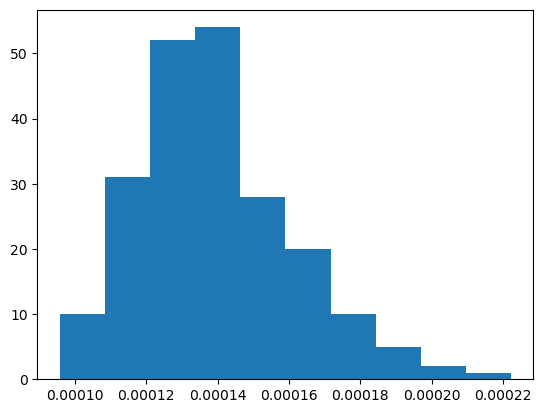

0.00013952926325282747
0.00022220643586479127


In [29]:
train_dataset2 = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform_test)
train_loader2 = DataLoader(train_dataset2, shuffle=False)

correct = 0
total = 0
test_pred = []
loss_list = []
with torch.no_grad():
    for data in train_loader2:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images).to(device).item()
        loss_list.append(loss)
# print(loss_list)
plt.hist(loss_list)
plt.show()
print(np.mean(loss_list))
m1 = np.percentile(np.array(loss_list), 98, axis=0)
print(m1)
            

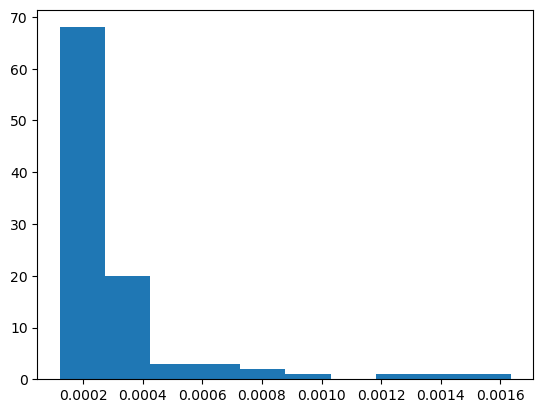

In [30]:
test_dataset = CustomDataset(csv_file=os.path.join(path,"test.csv"), transform=transform_test)
test_loader = DataLoader(test_dataset, shuffle=False)

correct = 0
total = 0
test_pred = []
loss_list = []
with torch.no_grad():
    for data in test_loader:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images).to(device).item()
        loss_list.append(loss)
        if loss<=m1 :#or loss>=m2:
            test_pred.append(0.)
        else:
            test_pred.append(1.)
plt.hist(loss_list)
plt.show()            

Text(50.722222222222214, 0.5, 'True Label')

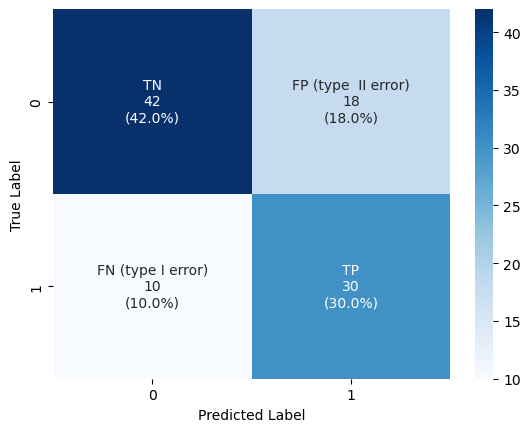

In [31]:
answer = [0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,1,0,0,1,1]
cf_matrix = confusion_matrix(answer, test_pred)
group_names = ["TN", "FP (type  II error)", "FN (type I error)", "TP"]
group_counts = [value for value in cf_matrix.flatten()]
group_percentages = [f"{value:.1%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
labels
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [32]:
submit = pd.read_csv(os.path.join(path,"sample_submission.csv"))
submit['label'] = test_pred
submit.head()

,id,label
0,TEST_000,1.0
1,TEST_001,1.0
2,TEST_002,0.0
3,TEST_003,0.0
4,TEST_004,0.0


In [33]:
submit.to_csv(os.path.join(save_path,"submit79.csv"), index=False)